# 1) Imports, load and prepare data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Data extracted from: https://www.realclearpolitics.com/epolls/2020/president/2020_elections_electoral_college_map.html

Methodology: States with clear runaway favorite are fully attributed to that candidate and excluded from analysis 

In [2]:
# load data
df = pd.read_excel('ElectionPolls.xlsx',delimiter=',')

In [3]:
df

,State,Electoral College Votes,Poll Trump,Poll Biden
0,Alabama,9,100.0,0.0
1,Alaska,3,45.0,39.0
2,Arizona,11,47.4,46.8
3,Arkansas,6,100.0,0.0
4,California,55,0.0,100.0
5,Colorado,9,39.0,48.5
6,Connecticut,7,0.0,100.0
7,D.C.,3,0.0,100.0
8,Delaware,3,0.0,100.0
9,Florida,29,47.2,48.4


In [4]:
# add column that indicates whether state is battleground state
df['Battleground'] = (df['Poll Trump'] != 0) * (df['Poll Trump'] != 100)  

In [5]:
# compute electoral collage votes from non-battleground states
trump_solid = (df.loc[~df['Battleground']]['Electoral College Votes'].to_numpy() * (df.loc[~df['Battleground']]['Poll Trump'].to_numpy() > df.loc[~df['Battleground']]['Poll Biden'].to_numpy())).sum()
biden_solid = (df.loc[~df['Battleground']]['Electoral College Votes'].to_numpy() * (df.loc[~df['Battleground']]['Poll Trump'].to_numpy() < df.loc[~df['Battleground']]['Poll Biden'].to_numpy())).sum()

In [6]:
print('Votes from non-battleground states for Trump: {}\nVotes from non-battleground states for Biden: {}'.format(trump_solid, biden_solid))

Votes from non-battleground states for Trump: 86
Votes from non-battleground states for Biden: 201


In [7]:
# create arrays for votes from battleground states and poll results per candidate 
votes = df.loc[df['Battleground']]['Electoral College Votes'].to_numpy()
trump = df.loc[df['Battleground']]['Poll Trump'].to_numpy()
biden = df.loc[df['Battleground']]['Poll Biden'].to_numpy()
size = len(votes)

# 2) Election simulation

**Methodology for election simulation:**

**1) Nation-level noise:** One candidate gets a fixed bonus (and the other the same fixed deduction), that is same for all states. This bonus/deduction is drawn from a normal distribution with mean 0 and standard deviation as provided by the 'nation_sigma' parameter. Nation-level noise is intended to model a nation-wide bias of the polls toward one candidate. (Base case: 0.5 p.p.)

**2) State-level noise:** One candidate gets a fixed bonus (and the other the same fixed deduction), that is different in each state and independent across states. This bonus/deduction is drawn from a normal distribution with mean 0 and standard deviation as provided by the 'state_sigma' parameter. State-level noise is intended to model a polls inherent uncertainty. (Base case: 3.5 p.p.)

**3) Trump bonus/deduction:** Explicit bonus for Trump and deduction for Biden as provided by the parameter 'trump_bonus'. This parameter can be used to manually change the poll prediction by the same percentage points across all states. It can be used to model a polling bias towards one candidate. (Base case: 0)

**4) Number of iterations:** Indicates the number of simulation iterations and is provided by the parameter 'n_runs' (Default: 1 million)

In [8]:
def simulate_election(sigma_state, sigma_nation, trump_bonus=0, n_runs=1000000):
    '''
    Simulates election outcomes per state for n_runs simulation iterations.

    Parameters:
    sigma_state: standard deviation of normal distribution for noise on state-level (independent across states)
    sigma_nation: standard deviation of normal distribution for noise on nation-level (same for all states)
    trump_bonus: bonus for trump (default: 0)
    n_runs: number of simulation iterations (default: 1 million)
    '''
    res = np.zeros([n_runs,size])
    for i in range(n_runs):
        nation_noise = np.random.normal() * sigma_nation
        state_noise = np.random.normal(size=size) * sigma_state
        trump_pred = trump + nation_noise + state_noise + trump_bonus
        biden_pred = biden - nation_noise - state_noise - trump_bonus
        res[i,] = trump_pred > biden_pred
    return res

In [9]:
def get_stats(sim_result):
    '''
    Computes summary statistics for simulation result.
    '''
    mean = (sim_result * votes).sum(axis=1).mean() + trump_solid
    std = (sim_result * votes).sum(axis=1).std()
    median = np.median((sim_result * votes).sum(axis=1)) + trump_solid
    mode = np.argmax(np.bincount(np.array((sim_result * votes).sum(axis=1),dtype='int'))) + trump_solid
    trump_prob = (((sim_result * votes).sum(axis=1) + trump_solid) >= 270).sum()/sim_result.shape[0]
    state_probs = sim_result.mean(axis=0)
    res = {'mean':mean,
    'std': std,
    'median': median,
    'mode': mode,
    'trump_prob': trump_prob,
    'state_probs': [state_probs]}
    return res

In [25]:
# Get base case simulation results
base_pred = simulate_election(3.5,0.5)
base_stats = get_stats(pred)

In [11]:
# set simulation parameters for scenario analysis
state_sigma = [1,2,3,4,5]
nation_sigma = [.25,.5,1,1.5,2]
trump_bonus = [0,.5,1,2]

In [13]:
# run simulations for scenario analysis
res = pd.DataFrame()
count = 0
n_iterations = len(state_sigma) * len(nation_sigma) * len(trump_bonus)
print('Total iterations: ', n_iterations)
for ss in state_sigma:
    for ns in nation_sigma:
        for tb in trump_bonus:
            stats = get_stats(simulate_election(ss,ns,tb))
            stats['state_sigma'] = ss
            stats['nation_sigma'] = ns
            stats['trump_bonus'] = tb
            res = res.append(pd.DataFrame(stats))
            count += 1
            print('Completed iteration: ', count)

Total iterations:  100
Completed iteration:  1
Completed iteration:  2
Completed iteration:  3
Completed iteration:  4
Completed iteration:  5
Completed iteration:  6
Completed iteration:  7
Completed iteration:  8
Completed iteration:  9
Completed iteration:  10
Completed iteration:  11
Completed iteration:  12
Completed iteration:  13
Completed iteration:  14
Completed iteration:  15
Completed iteration:  16
Completed iteration:  17
Completed iteration:  18
Completed iteration:  19
Completed iteration:  20
Completed iteration:  21
Completed iteration:  22
Completed iteration:  23
Completed iteration:  24
Completed iteration:  25
Completed iteration:  26
Completed iteration:  27
Completed iteration:  28
Completed iteration:  29
Completed iteration:  30
Completed iteration:  31
Completed iteration:  32
Completed iteration:  33
Completed iteration:  34
Completed iteration:  35
Completed iteration:  36
Completed iteration:  37
Completed iteration:  38
Completed iteration:  39
Completed i

In [14]:
res

,mean,std,median,mode,trump_prob,state_probs,state_sigma,nation_sigma,trump_bonus
0,197.250470,25.996567,198.0,198,0.000960,"[0.998206, 0.614594, 1e-06, 0.279899, 0.349467...",1,0.25,0.0
0,219.259457,25.423616,218.0,214,0.013061,"[0.999679, 0.780923, 1.9e-05, 0.461495, 0.5384...",1,0.25,0.5
0,240.369485,23.498285,243.0,259,0.085276,"[0.999945, 0.896265, 0.000162, 0.651733, 0.720...",1,0.25,1.0
0,275.137860,18.030966,278.0,279,0.624389,"[0.999999, 0.987277, 0.003779, 0.912439, 0.940...",1,0.25,2.0
0,197.521044,31.482148,198.0,198,0.006584,"[0.996355, 0.605807, 8e-06, 0.295439, 0.359497...",1,0.50,0.0
...,...,...,...,...,...,...,...,...,...
0,240.611884,39.856256,243.0,250,0.252812,"[0.830309, 0.670437, 0.298027, 0.605932, 0.620...",5,1.50,2.0
0,206.075423,46.493926,206.0,214,0.093123,"[0.711454, 0.522507, 0.188779, 0.456125, 0.470...",5,2.00,0.0
0,214.569916,46.466368,215.0,225,0.127000,"[0.742491, 0.558549, 0.214469, 0.492643, 0.507...",5,2.00,0.5
0,223.067083,46.182430,225.0,235,0.169682,"[0.771444, 0.594749, 0.243121, 0.530312, 0.544...",5,2.00,1.0


In [15]:
res.to_pickle('./results/results.pkl')

# 3) Visualize simulation results

In [16]:
colors = {'grey': '#666666',
'dark_blue': '#000045',
'light_blue': '#009dff',
'orange': '#ff9100'}

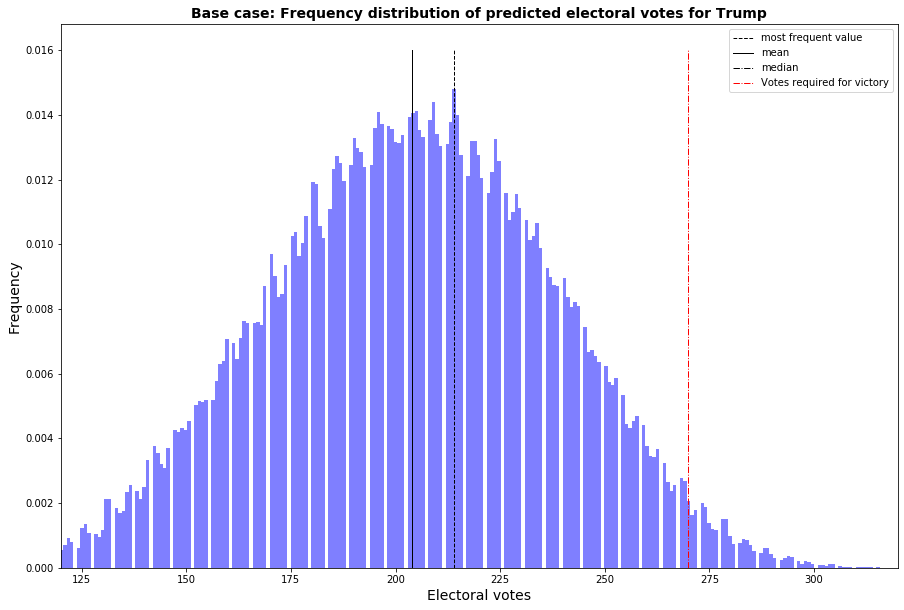

In [26]:
plt.figure(figsize=(15,10))
plt.hist(trump_solid + (base_pred * votes).sum(axis=1),bins=300, density=True, alpha=.5, color='blue')
plt.plot([base_stats['mode'],base_stats['mode']],[0,.016], linestyle='--', linewidth=1, color='black', label='most frequent value')
plt.plot([base_stats['mean'],base_stats['mean']],[0,.016], linestyle='-', linewidth=1, color='black', label='mean')
plt.plot([base_stats['median'],base_stats['median']],[0,.016], linestyle='dashdot', linewidth=1, color='black', label='median')
plt.plot([270,270],[0,.016], linestyle='dashdot', linewidth=1, color='red', label='Votes required for victory')
plt.xlim(120,320)
plt.title('Base case: Frequency distribution of predicted electoral votes for Trump', fontweight='bold', fontsize=14)
plt.xlabel('Electoral votes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend()
plt.savefig('./plots/base_case_histogram.png', dpi=600)

In [22]:
# Base case statistics
base_stats

{'mean': 203.877092,
 'std': 33.64096942157786,
 'median': 204.0,
 'mode': 214,
 'trump_prob': 0.021965,
 'state_probs': [array([0.80241 , 0.534045, 0.089881, 0.432662, 0.454297, 0.838604,
         0.567305, 0.838773, 0.051565, 0.28566 , 0.179005, 0.253362,
         0.801033, 0.388957, 0.286538, 0.101412, 0.432398, 0.501382,
         0.305443, 0.855811, 0.627596, 0.182807])]}

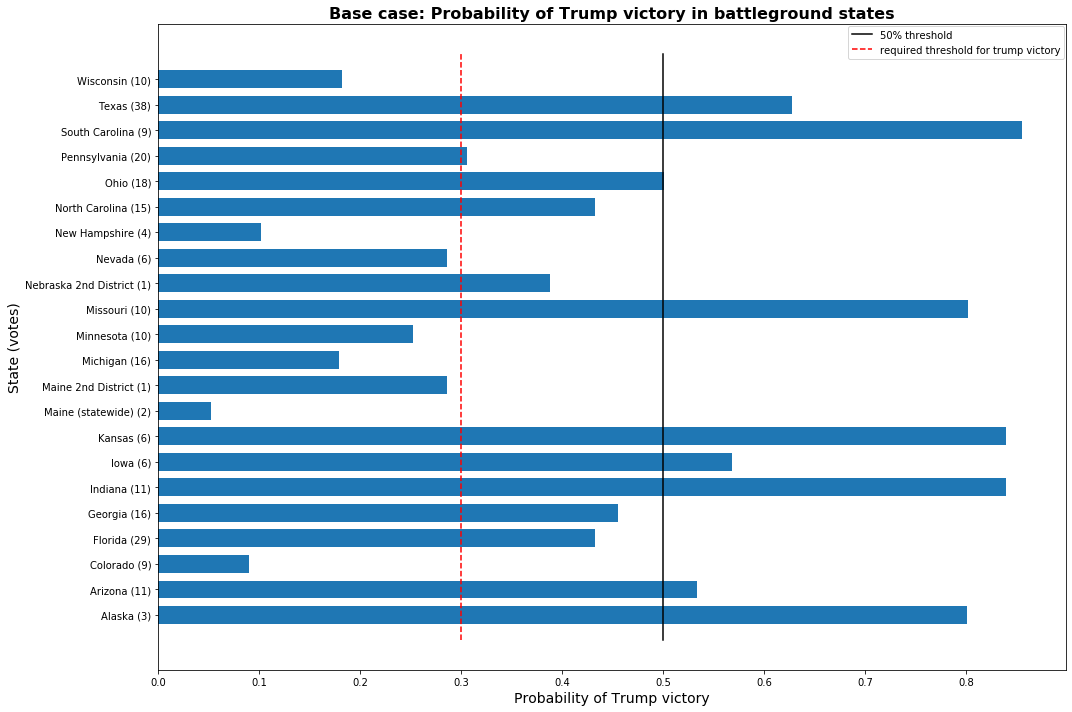

In [42]:
labels = df.loc[df['Battleground']].apply(lambda x: "{} ({})".format(x['State '],x['Electoral College Votes']), axis=1)
x = np.arange(len(labels))
width = .7

fig,ax = plt.subplots(figsize=(15,10))
ax.barh(x, base_pred.mean(axis=0),width)
ax.plot([.5,.5],[-1,len(labels)], linestyle='-', color='black', label='50% threshold')
ax.plot([.3,.3],[-1,len(labels)], linestyle='--', color='red', label='required threshold for trump victory')
ax.set_yticks(x)
ax.set_yticklabels(labels)
ax.set_ylabel('State (votes)',fontsize=14)
ax.set_xlabel('Probability of Trump victory',fontsize=14)
ax.set_title('Base case: Probability of Trump victory in battleground states',fontsize=16,fontweight='bold')
fig.legend(loc='upper right', bbox_to_anchor=(0.99, 0.96))
fig.tight_layout()
plt.savefig('./plots/base_case_stateProbs.png', dpi=600)

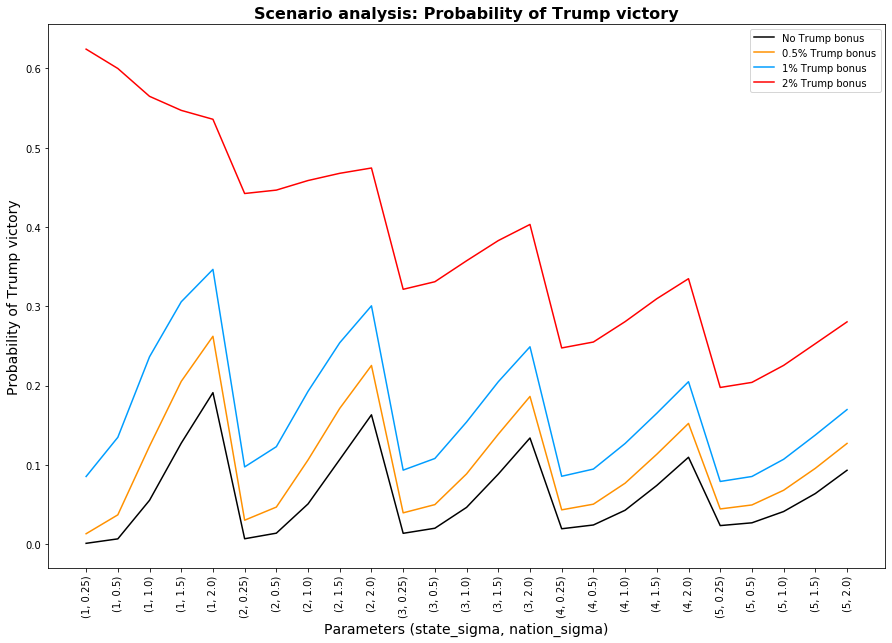

In [47]:
n_scenarios = len(state_sigma) * len(nation_sigma)
x = np.arange(n_scenarios)
label = res.loc[res['trump_bonus'] == 0].apply(lambda x: (x['state_sigma'],x['nation_sigma']), axis=1).to_numpy()

i = 0
fig,ax = plt.subplots(figsize=(15,10))
ax.plot(x,res.loc[res['trump_bonus'] == 0, 'trump_prob'], color='black', label='No Trump bonus')
ax.plot(x,res.loc[res['trump_bonus'] == 0.5, 'trump_prob'], color=colors['orange'], label='0.5% Trump bonus')
ax.plot(x,res.loc[res['trump_bonus'] == 1, 'trump_prob'], color=colors['light_blue'], label='1% Trump bonus')
ax.plot(x,res.loc[res['trump_bonus'] == 2, 'trump_prob'], color='red', label='2% Trump bonus')
ax.set_xticks([],[])
ax.set_ylabel('Probability of Trump victory',fontsize=14)
ax.set_title('Scenario analysis: Probability of Trump victory',fontsize=16,fontweight='bold')
ax.set_xticks(x)
ax.set_xlabel('Parameters (state_sigma, nation_sigma)',fontsize=14)
ax.set_xticklabels(label, rotation=90)

fig.legend(loc='upper right', bbox_to_anchor=(0.82, 0.86))
plt.savefig('./plots/scenario_analysis_victory_probability.png', dpi=600)

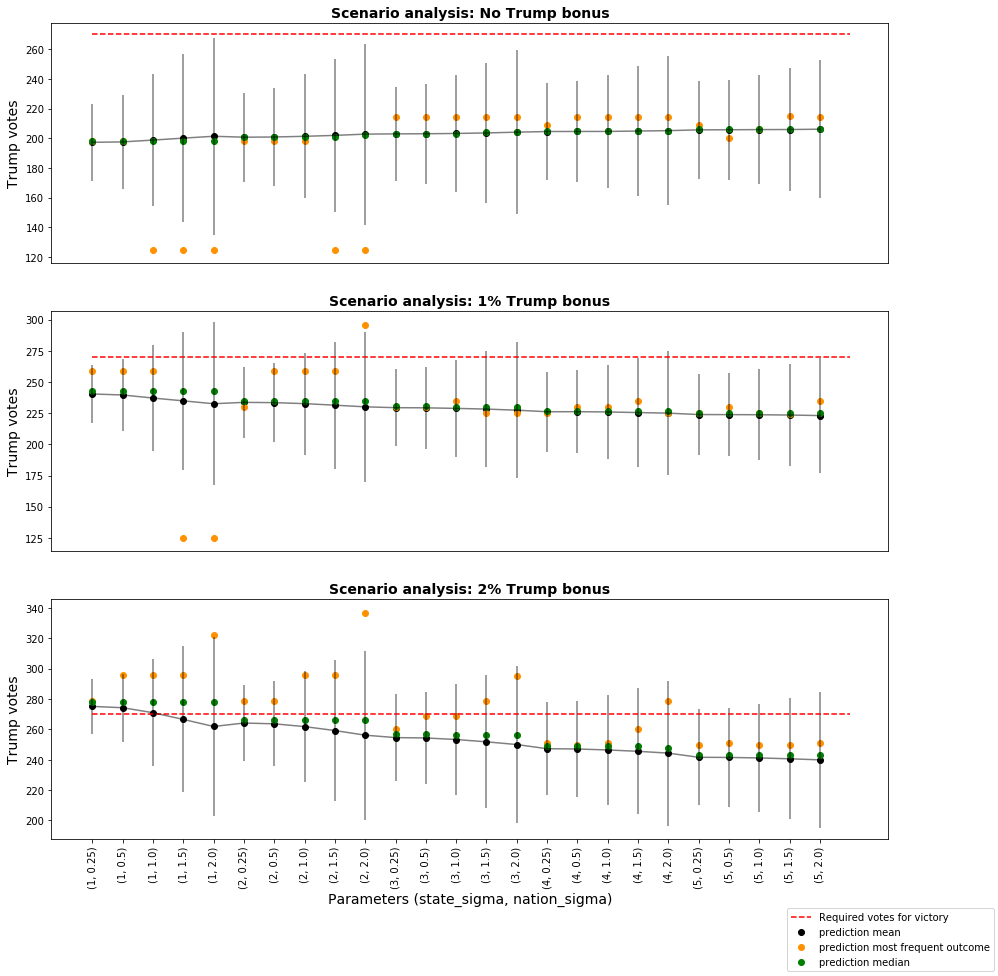

In [53]:
n_scenarios = len(state_sigma) * len(nation_sigma)
x = np.arange(n_scenarios)
label = res.loc[res['trump_bonus'] == 0].apply(lambda x: (x['state_sigma'],x['nation_sigma']), axis=1).to_numpy()

fig,axs = plt.subplots(3,1,figsize=(15,15))
i = 0
axs[i].errorbar(x,res.loc[res['trump_bonus'] == 0, 'mean'], yerr=res.loc[res['trump_bonus'] == 0, 'std'], color='black', alpha=.5)
axs[i].plot([0,n_scenarios],[270,270], linestyle='--', color='red')
axs[i].scatter(x,res.loc[res['trump_bonus'] == 0, 'mean'], color='black')
axs[i].scatter(x,res.loc[res['trump_bonus'] == 0, 'mode'], color=colors['orange'])
axs[i].scatter(x,res.loc[res['trump_bonus'] == 0, 'median'], color='green')
axs[i].set_xticks([],[])
axs[i].set_ylabel('Trump votes',fontsize=14)
axs[i].set_title('Scenario analysis: No Trump bonus',fontsize=14,fontweight='bold')

i = 1
axs[i].errorbar(x,res.loc[res['trump_bonus'] == i, 'mean'], yerr=res.loc[res['trump_bonus'] == i, 'std'], color='black', alpha=.5)
axs[i].plot([0,n_scenarios],[270,270], linestyle='--', color='red')
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'mean'], color='black')
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'mode'], color=colors['orange'])
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'median'], color='green')
axs[i].set_xticks([],[])
axs[i].set_ylabel('Trump votes',fontsize=14)
axs[i].set_title('Scenario analysis: 1% Trump bonus',fontsize=14,fontweight='bold')

i = 2
axs[i].errorbar(x,res.loc[res['trump_bonus'] == i, 'mean'], yerr=res.loc[res['trump_bonus'] == i, 'std'], color='black', alpha=.5)
axs[i].plot([0,n_scenarios],[270,270], linestyle='--', color='red', label='Required votes for victory')
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'mean'], color='black', label='prediction mean')
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'mode'], color=colors['orange'], label='prediction most frequent outcome')
axs[i].scatter(x,res.loc[res['trump_bonus'] == i, 'median'], color='green', label='prediction median')
axs[i].set_xticks(x)
axs[i].set_xlabel('Parameters (state_sigma, nation_sigma)',fontsize=14)
axs[i].set_ylabel('Trump votes',fontsize=14)
axs[i].set_title('Scenario analysis: 2% Trump bonus',fontsize=14,fontweight='bold')

axs[i].set_xticklabels(label, rotation=90)

fig.legend(loc='lower right')
plt.savefig('./plots/scenario_analysis_details.png', dpi=600)